# Tutorial 04 - Filters

## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Digital Imaging / Computer Vision** techniques.


# Contents

Table of Contents  
- [Filters in OpenCV](#Filters)
    - Average Filter
    - Gaussian Filter
    - Border Handling
- [Fourier Transformation](#Fourier_Spectrum)
    - FFT of Images
    - Inverse FFT
    - Convolution Theorem

# Initilization

As always let's import useful libraries, first.

In [10]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

We will work with images today. So let's download some with `curl` (the same sources as in previous sessions).

In [11]:
!curl -o "cat.jpg" "https://placekitten.com/256/256" --silent
!curl -o "gogh.jpg" "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Vincent_van_Gogh_-_National_Gallery_of_Art.JPG/367px-Vincent_van_Gogh_-_National_Gallery_of_Art.JPG" --silent

Let's define the `imshow` utility function to display images, in Jupyter Notebooks. 
The function primary takes care of handling color-channel differences (RGB vs. BGR).

In [12]:
def imshow(image:np.ndarray, library:str = 'matplotlib', show:bool=False, scale:bool=False, *args, **kwargs):
    """A function to display images in Jupyter Notebooks.

    Args:
        image (np.ndarray): The image to display.
        library (str, optional): The library to use to display the image. Defaults to 'matplotlib'. 
        show (bool, optional): calls `fig.show()/plt.show()`. Defaults to False.
        scale (bool, optional): Scales the image to 0-255. Defaults to False.
    """
    image = image.copy()
    if scale: 
      image = cv2.normalize(image, image, 255, 0, cv2.NORM_MINMAX)
    image = np.clip(image, 0, 255).astype(np.uint8)
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    if library == 'matplotlib':
      # Draw the image
      plt.imshow(image, *args, **kwargs)
      # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
      plt.axis('off')
      # Make sure it outputs
      if show: plt.show()
    elif library == 'plotly':
      fig = px.imshow(image, *args, **kwargs)
      if show: fig.show()

# Filters <a name="Filters" id="Filters"> </a>

Image filters in OpenCV are applied with `cv2.filter2D(img,-1,kernel)`, where the image and the kernel are numpy arrays.


## Average

Let's start with a simple average filter

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


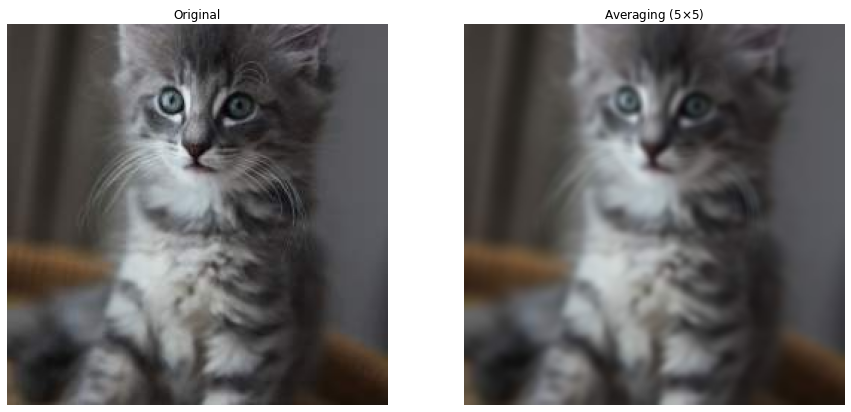

In [13]:
img = cv2.imread('cat.jpg')

k = 5 # kernel size
kernel = np.ones((k,k),np.float32)/(k**2)
print(kernel)
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the filter results clearer
plt.subplot(121),imshow(img),plt.title('Original')
plt.subplot(122),imshow(dst),plt.title(r'Averaging ({}$\times${})'.format(k,k))
plt.show()

## Gaussian Filter

An average filter produces blocky or boxy results, that's why it is also called a box filter. A smoother result can be achieved with a Gaussian Kernel. 
OpenCV's `getGaussianKernel` function produces a one-dimensional seperable Gaussian kernel. To retrieve the 2D variant, we need to (matrix) multiply two 1D kernel.  

[[0.0625 0.25   0.375  0.25   0.0625]]
[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


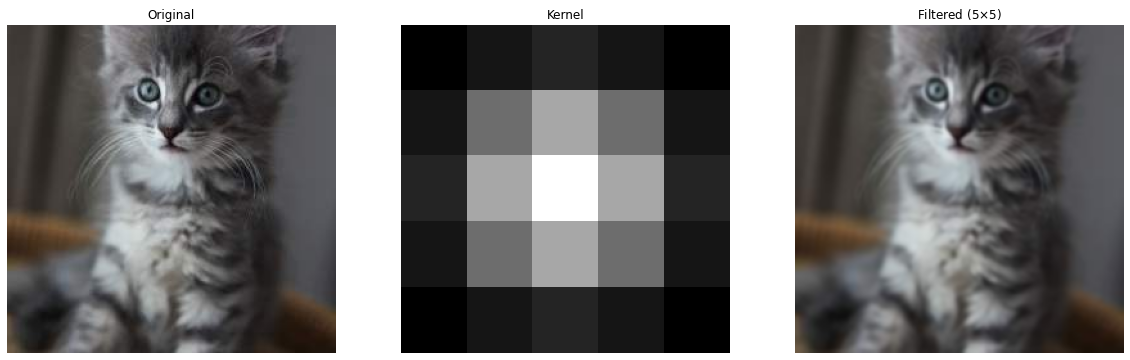

In [14]:
img = cv2.imread('cat.jpg')

k = 5 # kernel size and sigma
kernel = cv2.getGaussianKernel(k,-1)
print(kernel.T)
kernel = kernel @ kernel.T # compute 2D from seperable kernel
print(kernel)
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(20,15)) # make the figure larger
plt.subplot(131),imshow(img),plt.title('Original')
plt.subplot(132),imshow(kernel, cmap = 'gray', scale=True),plt.title('Kernel')
plt.subplot(133),imshow(dst),plt.title(r'Filtered ({}$\times${})'.format(k,k))
plt.show()

## Border handling

Border handling especially for large kernels is important. OpenCV provides various options. Default is to reflect the image at the border. 

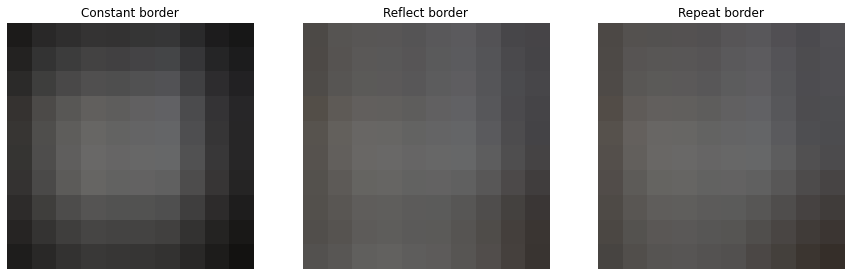

In [15]:
img = cv2.resize( cv2.imread('cat.jpg'), (10,10) )

k = 7 # kernel size and sigma
kernel = np.ones((k,k),np.float32)/(k**2)
const   = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_CONSTANT)   # 000000|abcdefgh|0000000
reflect = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REFLECT)    # fedcba|abcdefgh|hgfedcb
repeat  = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE)  # aaaaaa|abcdefgh|hhhhhhh


plt.figure(figsize=(15,10)) # make the figure larger
plt.subplot(131),imshow(const),  plt.title(r'Constant border')
plt.subplot(132),imshow(reflect),plt.title(r'Reflect border')
plt.subplot(133),imshow(repeat), plt.title(r'Repeat border')
plt.show()

## Exercise 1 📝: Your average filter <a name="Exercise_1" id="Exercise_1"> </a>

**Mean Filter:** Implement an average filter yourself. Do not use any OpenCV functions (i.e., `filter2D`).
Hint: you can use loops or slicing.

**(a)** Load the image `gogh.jpg` and apply a $3 \times 3$ filter on the image. Ignore the border (remove 1 pixel at the border).




In [16]:
# Setup Excercise 1

image = cv2.imread("gogh.jpg")
k = 3 # filter size

# use opencv for reference
kernel = np.ones((k,k),np.float32)/(k**2)
ref = cv2.filter2D(image,-1,kernel)
ref = ref[1:-1,1:-1,:] # remove border

def MSE(A,B):
  """compute the mean squared error (MSE) between numpy array A and B
  """
  return ((A - B)**2).mean(axis=None)

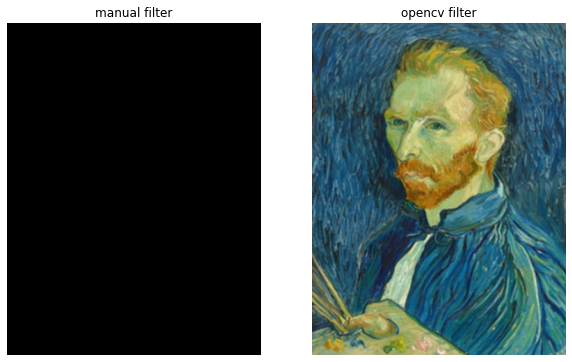

MSE: 108.65152939378308


AssertionError: 

In [17]:
# Solution (a)

avg = np.zeros(image.shape,dtype=np.float32)

# compute average
# Todo!

# remove border
avg = np.round(avg[0:-2,0:-2,:]).astype(np.uint8)

# display
plt.figure(figsize=(10,10))
plt.subplot(121), imshow(avg), plt.title('manual filter')
plt.subplot(122), imshow(ref), plt.title('opencv filter')
plt.show()

# compute MSE
print( f'MSE: {MSE(avg,ref)}' )

# check if close to reference
assert np.isclose(avg,ref).all() == True # if everything is implemented correctly this should not cause an error!


# Fourier Spectrum <a class="anchor" id="Fourier_Spectrum"></a>

## Fourier Transformation of Images

The numpy library provides a two-dimensional implementation of the Fast Fourier Transformation (FFT): `numpy.fft.fft2`. 
The resulting spectrum is an array with complex numbers, which are supported by numpy. 
We can visualize the spectrum by displaying it like a regular image. Since it is complex we will show only the magnitude (with `numpy.abs`) and we'll use a logarithmic scale. 

dtype('complex128')


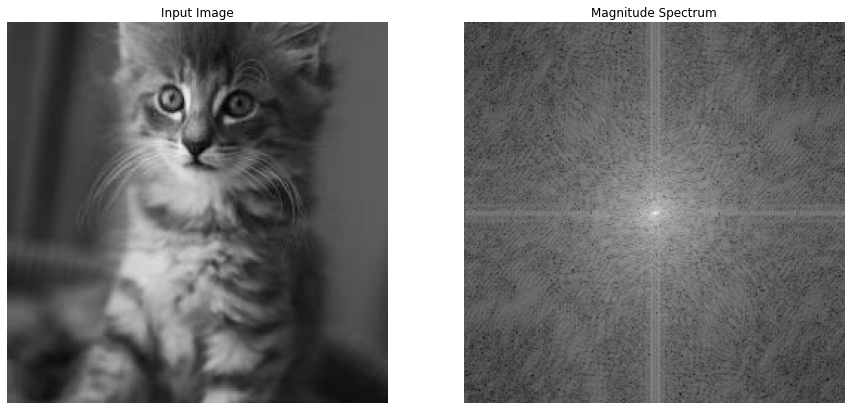

In [20]:
# Load an image and convert it to grayscale
gray = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_RGB2GRAY)

# Transform the image to frequency domain
f = np.fft.fft2(gray)
print(repr(f.dtype))
# Bring the zero-frequency component to the center
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(gray, cmap = 'gray'), plt.title('Input Image')
plt.subplot(122), imshow(magnitude_spectrum, cmap = 'gray', scale = True), plt.title('Magnitude Spectrum')
plt.show()

## Inverse Fourier Transformation

While the FFT transform a signal into its spectral domain, the inverse FFT (`numpy.fft.ifft2`) transforms a spectrum into the spatial domain. Note that the resulting array is complex again, where the complex part is zero (or close to zero). 

complex128


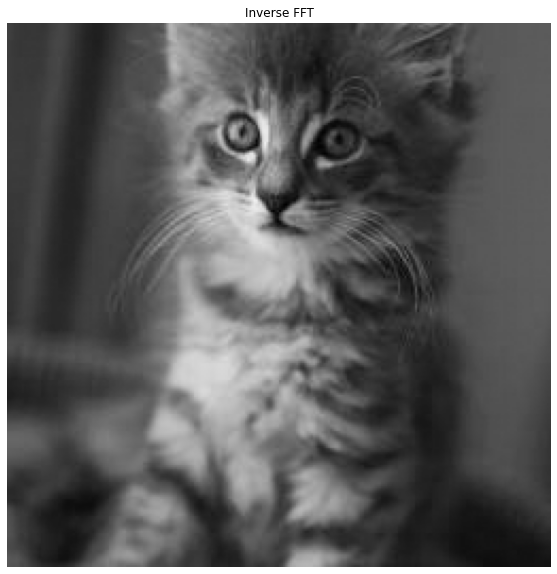

In [21]:
# inverse fourier transform
iff = np.fft.ifft2(f)
print(iff.dtype)
#print(repr(iff))

plt.figure(figsize=(15,10)), imshow(np.abs(iff), cmap='gray'), plt.title('Inverse FFT')
plt.show()

Let's look at some artificial spectra and the corresponding signal. 

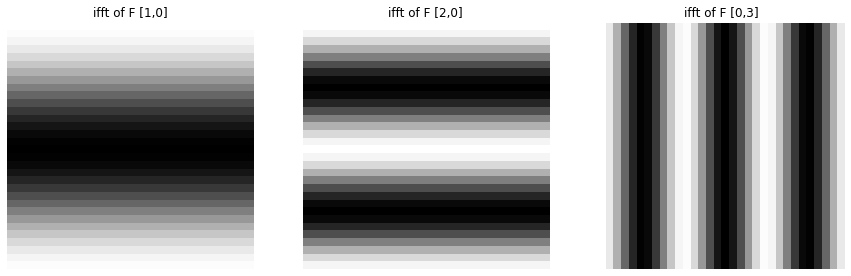

In [22]:
F = np.zeros((32,32),dtype=np.complex128)
F[0,0] = np.prod(F.shape) # DC component (mean)
F10 = F.copy()
F10[1,0] = 1.0
f10 = np.fft.ifft2(F10)

F20 = F.copy()
F20[2,0] = 1.0
f20 = np.fft.ifft2(F20)

F03 = F.copy()
F03[0,3] = 1.0
f03 = np.fft.ifft2(F03)

plt.figure(figsize=(15,10))
plt.subplot(131), imshow(np.abs(f10), cmap='gray', scale=True), plt.title('ifft of F [1,0]')
plt.subplot(132), imshow(np.abs(f20), cmap='gray', scale=True), plt.title('ifft of F [2,0]')
plt.subplot(133), imshow(np.abs(f03), cmap='gray', scale=True), plt.title('ifft of F [0,3]')
plt.show()

## Exercise 2 📝: The frequencies of a checkerboard 🏁

Create an image of a 2D checkerboard. Do so by modifying the frequency domain and transforming it back to the spatial domain.
Hint: think about the checkers as a diagonal sine wave. 

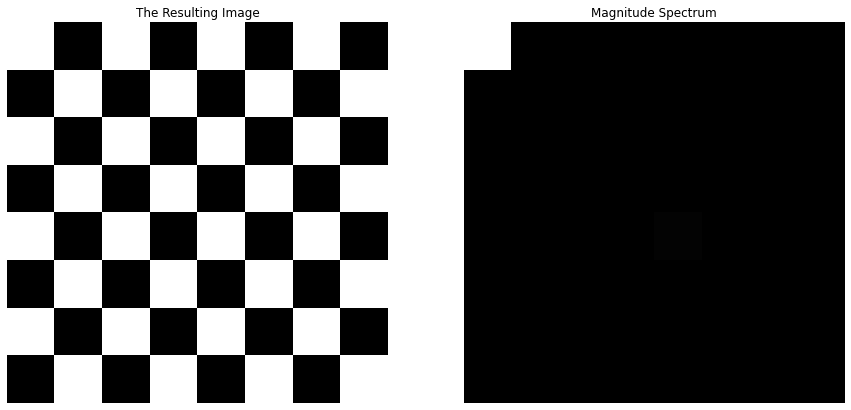

In [18]:
F = np.zeros((8,8),dtype=np.complex128)
F[0,0] = np.prod(F.shape) # DC component (mean)

# Todo: create a checkerboard pattern in frequency domain

# inverse fourier transform
f = np.fft.ifft2(F)


plt.figure(figsize=(15,10))
plt.subplot(121), imshow(np.abs(f), cmap = 'gray', scale = True), plt.title('The Resulting Image')
plt.subplot(122), imshow(np.abs(F), cmap = 'gray', scale = True), plt.title('Magnitude Spectrum')
plt.show()


## Modifications in the Fourier Spectrum

Let's remove some frequencies by setting them to zero in the spectrum. By converting the spectrum back in the spatial domain (`ifft2`) we can look at the results in the image.

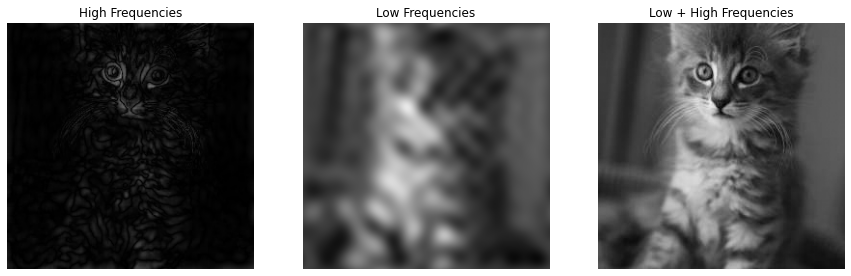

In [23]:
rows, cols = gray.shape
crow, ccol = round(rows/2) , round(cols/2)

# remove low frequencies with a rectangle size of 20
fcopy = fshift.copy()
fcopy[crow-10:crow+10, ccol-10:ccol+10] = 0
f_ishift = np.fft.ifftshift(fcopy)
img_hf = np.fft.ifft2(f_ishift)
plt.figure(figsize=(15,10))
plt.subplot(131), plt.title( 'High Frequencies')
imshow(np.abs(img_hf), cmap='gray')

# remove high frequencies
fcopy = np.zeros_like(fshift)
fcopy[crow-10:crow+10, ccol-10:ccol+10] = fshift[crow-10:crow+10, ccol-10:ccol+10]
f_ishift = np.fft.ifftshift(fcopy)
img_lf = np.fft.ifft2(f_ishift)
plt.subplot(132), plt.title( 'Low Frequencies')
imshow(np.abs(img_lf), cmap='gray')

# sum the low and high frequencies (Note: it is important to avoid using abs)
plt.subplot(133), plt.title( 'Low + High Frequencies')
imshow(np.abs(img_lf+img_hf), cmap='gray')

## Convolution Theorem

 

A convolution is a point-wise operation in the spectral domain. 
Let's try this with our images. 
For very large kernels OpenCV's filter function uses FFT to speed up computations. 

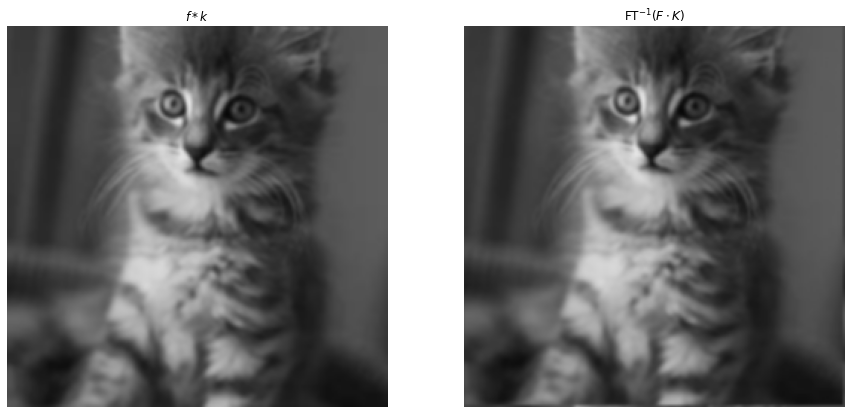

In [24]:
# Load an image and convert it to grayscale
f = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_RGB2GRAY)
# Transform the image to frequency domain
F = np.fft.fft2(f)

rows, cols = f.shape
crow, ccol = round(rows/2) , round(cols/2)

# create a kernel
k_size = 5 # kernel size and sigma
kh = int(np.floor(k_size/2.0))
kernel = cv2.getGaussianKernel(k_size,-1) 
kernel = kernel @ kernel.T # compute 2D from seperable kernel
k = np.zeros(f.shape)
k[crow-kh-1:crow+kh, ccol-kh-1:ccol+kh] = kernel # extend the size of the kernel
K = np.fft.fft2(k)

# apply the convolution in the spatial domain
d = cv2.filter2D(f,-1,k)

# apply a multiplication in the frequency domain
D = np.zeros_like(F)
D = F * K
D_back = np.fft.ifftshift(np.fft.ifft2(D))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(np.abs(d), cmap='gray'), plt.title('$f * k$')
plt.subplot(122), imshow(np.abs(D_back), cmap='gray'), plt.title(r'FT$^{-1}( F \cdot K )$')
plt.show()